In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
from dss.env import AlpacaEnv
from dss.transformation import SentenceTransformerFeature

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.data import Dataset
from os import path
import torch
import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

/scratch/t.tovi/packages/dss/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Try this new env

In [3]:
env = AlpacaEnv(use_raw=False, collator="all")

Loading precomputed features...


In [4]:
env = DummyVecEnv([lambda: AlpacaEnv(use_raw=False, collator="all", cov_metric="dissimilarity")])

Loading precomputed features...


In [17]:
# Train the policy using PPO
retrain = True
agent = PPO("MlpPolicy", env, gae_lambda=0, verbose=1)
if path.exists("playground/ppo_alpaca_instruct.zip") and not retrain:
    agent = PPO.load("playground/ppo_alpaca_instruct.zip", env=env)
else:
    agent.learn(total_timesteps=int(3e5))
    agent.save("playground/ppo_alpaca_instruct")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 936  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 767         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015945308 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | -0.952      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0459     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 0.00481     |
-----------------------------------------
----------------

# Let us measure diversity

In [18]:
train_dataset = env.envs[0].dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

X = []
V = []
data_values = []
for datum in tqdm.tqdm(train_loader):
    state = datum['feature']
    v, log_likelihoods, _ = agent.policy.evaluate_actions(state.to(0), torch.tensor([0, 1]).to(0))
    
    datum_value = log_likelihoods[1].cpu().item()
    V.append(v.cpu().detach().item())

    X.append(datum)
    data_values.append(datum_value)

  0%|          | 0/52002 [00:00<?, ?it/s]

100%|██████████| 52002/52002 [00:48<00:00, 1075.73it/s]


In [19]:
X_ = [x for x, _ in sorted(zip(X, data_values), key=lambda x: x[-1], reverse=True)]
X_ = np.array(X_)

In [36]:
X_[-17]

{'instruction': ['Make a list of at least four tasks for a given profession.'],
 'input': ['Chef'],
 'output': ['- Prepare meals according to recipes\n- Monitor food quality and presentation\n- Ensure all food safety regulations are met\n- Manage food costs and maintain inventory\n- Order and purchase food supplies\n- Develop new dishes and menu items'],
 'text': ['Chef Make a list of at least four tasks for a given profession. - Prepare meals according to recipes\n- Monitor food quality and presentation\n- Ensure all food safety regulations are met\n- Manage food costs and maintain inventory\n- Order and purchase food supplies\n- Develop new dishes and menu items'],
 'feature': tensor([[ 2.1449e-02,  2.7722e-02, -1.3634e-02, -1.1522e-02, -2.5029e-02,
           1.2366e-02,  4.2838e-02, -3.9174e-02,  1.3717e-02,  1.1655e-02,
           5.0292e-02,  1.5770e-02,  1.4124e-02, -2.9083e-02, -2.9164e-03,
          -5.3536e-02, -3.0796e-02, -1.6874e-03, -2.4071e-02, -1.3025e-02,
          -7.

In [15]:
cosine_distances_max = []
covariances_max = []

for size in range(1, 52, 5):

    indices = np.arange(int(size/100*len(X_)))
    samples = X_[indices]
    samples = np.array([s['feature'].numpy() for s in samples])
    samples = samples.reshape(samples.shape[0], -1)
    samples = torch.from_numpy(samples)
    covariances_max.append(torch.diag(torch.cov(samples.T)).sum())
    cosine_distances_max.append(np.mean(cosine_distances(samples.cpu().numpy())))

In [16]:
cosine_distances_min = []
covariances_min = []

for size in range(1, 52, 5):

    indices = -np.arange(int(size/100*len(X_)))
    samples = X_[indices]
    samples = np.array([s['feature'].numpy() for s in samples])
    samples = samples.reshape(samples.shape[0], -1)
    samples = torch.from_numpy(samples)
    covariances_min.append(torch.diag(torch.cov(samples.T)).sum())
    cosine_distances_min.append(np.mean(cosine_distances(samples.cpu().numpy())))

In [17]:
cosine_distances_random = []
covariances_random = []

for size in range(1, 52, 5):

    indices = np.random.choice(len(X_), int(size/100*len(X_)), replace=False)
    samples = X_[indices]
    samples = np.array([s['feature'].numpy() for s in samples])
    samples = samples.reshape(samples.shape[0], -1)
    samples = torch.from_numpy(samples)
    covariances_random.append(torch.diag(torch.cov(samples.T)).sum())
    cosine_distances_random.append(np.mean(cosine_distances(samples.cpu().numpy())))

## Compare it with DPP

In [12]:
from sklearn.metrics.pairwise import rbf_kernel

F_ = [x['feature'].flatten() for x in X_]
F_ = torch.stack(F_)

kernel_matrix = rbf_kernel(F_.cpu().numpy(), gamma=0.5)

In [13]:
from dss.utils import dpp

max_size = int(0.51 * len(X_))
selected_indices_ = dpp(kernel_matrix, max_size)

In [16]:
cosine_distances_dpp = []
covariances_dpp = []

for percentage in range(1, 52, 5):
    size_ = len(X_) * percentage // 100
    samples = F_[selected_indices_[:size_]]
    cosine_distances_dpp.append(np.mean(cosine_distances(samples.cpu().numpy())))
    covariances_dpp.append(torch.diag(torch.cov(samples.T)).sum())

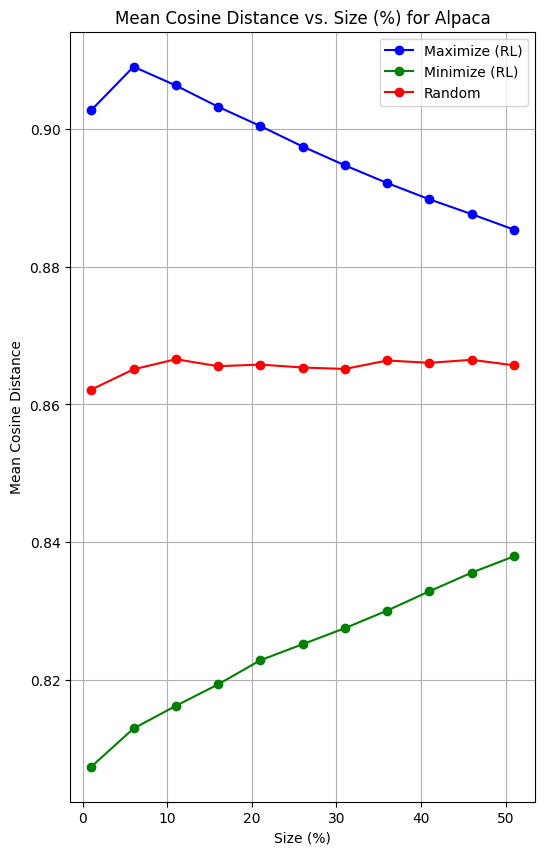

In [18]:
sizes = range(1, 52, 5)

plt.figure(figsize=(6, 10))
plt.plot(sizes, cosine_distances_max, marker='o', linestyle='-', color='b', label='Maximize (RL)')
plt.plot(sizes, cosine_distances_min, marker='o', linestyle='-', color='g', label='Minimize (RL)')
plt.plot(sizes, cosine_distances_random, marker='o', linestyle='-', color='r', label='Random')
# plt.plot(sizes, cosine_distances_dpp, marker='o', linestyle='-', color='purple', label='Greedy DPP')

# Updating labels and title for the plot
plt.xlabel('Size (%)')
plt.ylabel('Mean Cosine Distance')
plt.title('Mean Cosine Distance vs. Size (%) for Alpaca')
plt.legend()
plt.grid(True)
plt.show()

## Save the dataset

In [22]:
to_save = [{k:v[0] for k,v in d.items() if k!="feature"} for d in X_]

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/llama-2-7b-hf")

to_save = [entry for entry in to_save if tokenizer(entry['context'])["input_ids"][0].__len__() <= 1024]

In [14]:
import json

with open ("playground/alpaca_3k_dss.json", "w") as f:
    json.dump(to_save[:3000], f)

In [26]:
with open ("playground/alpaca_3k_dss_least.json", "w") as f:
    json.dump(to_save[-3000:], f)

In [29]:
to_save[-7]

{'instruction': 'Create a tagline that summarizes the idea of the product or service presented in the sentence.',
 'input': 'Our company offers customized software solutions for businesses that need help managing their data.',
 'output': 'Data management made easy - with our customized software solutions.',
 'text': 'Our company offers customized software solutions for businesses that need help managing their data. Create a tagline that summarizes the idea of the product or service presented in the sentence. Data management made easy - with our customized software solutions.'}

In [15]:
import json

random_save = np.array(to_save)
random_save = random_save[np.random.choice(len(random_save), 3000, replace=False)]
with open ("playground/alpaca_3k_random.json", "w") as f:
    json.dump(random_save.tolist(), f)

# Ablation

In [3]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_rewards = []
curve_rewards = []

env = DummyVecEnv([lambda: AlpacaEnv(use_raw=False, collator="all", cov_metric="dissimilarity")])
agent = PPO("MlpPolicy", env, verbose=0)

total_steps = 5e5
eval_period = 1e4
for i in range(int(total_steps // eval_period)):
    agent.learn(total_timesteps=int(eval_period), reset_num_timesteps=False)
    agent.save(f"playground/ppo_alpaca_instruct_{i}")

    # Reward
    mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=1)
    mean_rewards.append(mean_reward)

    # Diversity Curve
    train_dataset = env.envs[0].dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

    if (i+1) % 5 == 0:

        X = []
        data_values = []
        for datum in tqdm.tqdm(train_loader):
            state = datum['feature']
            _, log_likelihoods, _ = agent.policy.evaluate_actions(state.to(0), torch.tensor([0, 1]).to(0))
            
            datum_value = log_likelihoods[1].cpu().item()

            X.append(datum)
            data_values.append(datum_value)
        X_ = [x for x, _ in sorted(zip(X, data_values), key=lambda x: x[-1], reverse=True)]
        X_ = np.array(X_)

        cosine_distances_max = []

        for size in range(1, 52, 5):

            indices = np.arange(int(size/100*len(X_)))
            samples = X_[indices]
            samples = np.array([s['feature'].numpy() for s in samples])
            samples = samples.reshape(samples.shape[0], -1)
            samples = torch.from_numpy(samples)
            cosine_distances_max.append(np.mean(cosine_distances(samples.cpu().numpy())))
            
        curve_rewards.append(cosine_distances_max)

Using the latest cached version of the dataset since tatsu-lab/alpaca couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /ib-scratch/chenguang01/huggingface/datasets/tatsu-lab___alpaca/default/0.0.0/dce01c9b08f87459cf36a430d809084718273017 (last modified on Fri Nov 29 03:15:00 2024).
/ib-scratch/chenguang02/t.tovi/code/DSS-RL/dss/env.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

Loading precomputed features...


/scratch/t.tovi/packages/rl-project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
100%|██████████| 52002/52002 [00:50<00:00, 1020.06it/s]
/scratch/t.tovi/packages/rl-project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
100%|██████████| 52002/52002 [00:50<00:00, 1028.45it/s]
/scratch/t.tovi/packages/rl-project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation enviro

In [35]:
reward_data = np.array([
    [0.9026777, 0.90333796, 0.90075964, 0.8984911, 0.8952076, 0.89264476, 0.8905635, 0.8885424, 0.886495, 0.8842582, 0.8823221],
    [0.9180605, 0.9173298, 0.91476315, 0.9111906, 0.90860873, 0.90579706, 0.9028577, 0.90055627, 0.8978562, 0.89506257, 0.8928421],
    [0.9050272, 0.9164791, 0.91699636, 0.91556793, 0.91338795, 0.911327, 0.90906876, 0.9067347, 0.9043618, 0.9019828, 0.89934653],
    [0.9191387, 0.92780143, 0.9274339, 0.92535496, 0.92252034, 0.9197516, 0.9169232, 0.9142018, 0.9112355, 0.908014, 0.90479404],
    [0.9352874, 0.93946, 0.93648714, 0.9330857, 0.9296814, 0.92633635, 0.92266786, 0.9192347, 0.9159418, 0.9125201, 0.90897024],
    [0.9351705, 0.93562984, 0.9331614, 0.93068945, 0.9279493, 0.9254141, 0.9224658, 0.91914487, 0.9160527, 0.91294885, 0.9096391],
    [0.94708955, 0.94567645, 0.9408877, 0.93745726, 0.9339717, 0.9304082, 0.9269994, 0.92357045, 0.9200828, 0.9165242, 0.9126989],
    [0.944987, 0.945399, 0.942185, 0.9382741, 0.9346232, 0.93098193, 0.92701954, 0.9234727, 0.9198291, 0.9161377, 0.91231185],
    [0.94653904, 0.9478304, 0.94347686, 0.93901217, 0.9351363, 0.93152946, 0.9277112, 0.9238959, 0.9201784, 0.9165509, 0.91293365],
    [0.9493594, 0.94864976, 0.9436965, 0.9395473, 0.9350727, 0.9307421, 0.9270061, 0.9230936, 0.9192408, 0.9155333, 0.9115736]
])

# X-axis (percentage from 1% to 51%)
x = np.linspace(1, 51, reward_data.shape[1])

# Normalize the number of training steps for color mapping
num_steps = np.arange(50000, 50000 * (reward_data.shape[0] + 1), 50000)
colors = plt.cm.viridis(np.linspace(0, 1, len(num_steps)))

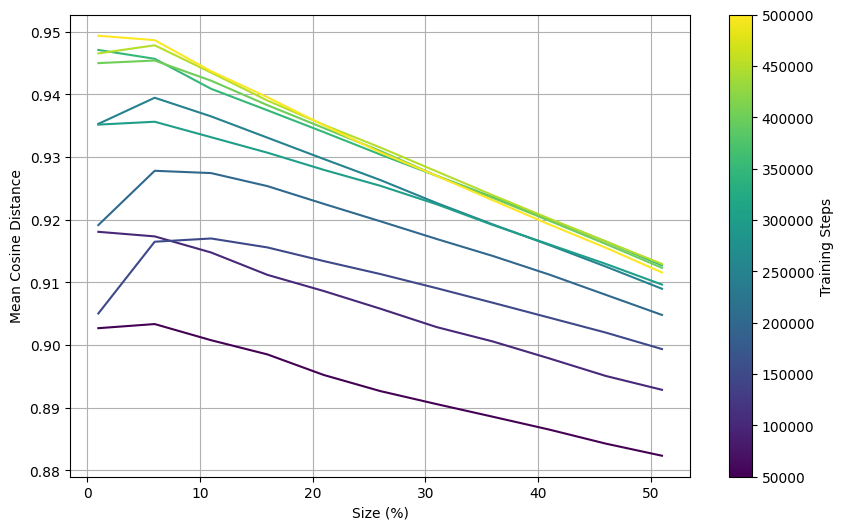

In [36]:
import matplotlib as mpl

# Plotting the reward data with a color map legend
plt.figure(figsize=(10, 6))
for i, (rewards, color) in enumerate(zip(reward_data, colors)):
    plt.plot(x, rewards, color=color)

# Create a colorbar as the legend for training steps
sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=num_steps.min(), vmax=num_steps.max()))
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Training Steps')

plt.xlabel('Size (%)')
plt.ylabel('Mean Cosine Distance')
plt.grid(True)
plt.show()

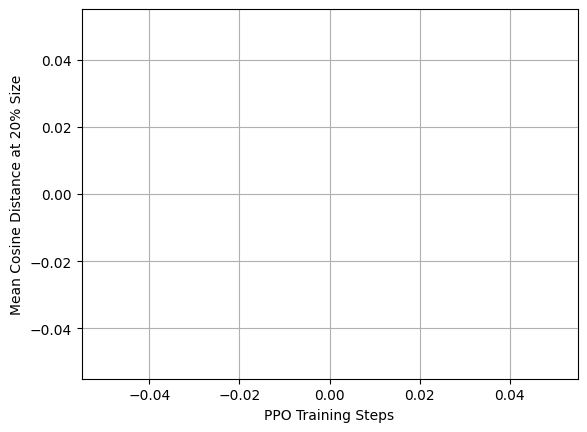

In [37]:
x = np.linspace(5000, 50000, len(mean_rewards))
plt.plot(x, mean_rewards, linestyle='-', color='b', label='Maximize (RL)')

plt.xlabel('PPO Training Steps')
plt.ylabel('Mean Cosine Distance at 20% Size')
plt.grid(True)
plt.show()

In [34]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_rewards = []
curve_rewards = []

total_steps = 5e5
eval_period = 5e4
for i in range(int(total_steps // eval_period)):
    limit = 0.01 + i * 0.05
    print(f"Limit: {limit}")
    env = DummyVecEnv([lambda: AlpacaEnv(use_raw=False, collator="all", cov_metric="dissimilarity", limit=limit)])
    agent = PPO("MlpPolicy", env, verbose=0)
    agent.learn(total_timesteps=1e5, reset_num_timesteps=True)
    agent.save(f"playground/ppo_alpaca_instruct_{i}")

    # Reward
    mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=1)
    mean_rewards.append(mean_reward)

Limit: 0.01
Loading precomputed features...


/ib-scratch/chenguang02/t.tovi/code/DSS-RL/dss/env.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.features = torch.load(f"playground/{name}.pt")


KeyboardInterrupt: 

> /scratch/t.tovi/packages/rl-project/lib/python3.10/site-packages/torch/_ops.py(953)__call__()
    951             with self._register_as_effectful_op_temporarily():
    952                 return self._dispatch_in_python(args, kwargs, self._fallthrough_keys())
--> 953         return self._op(*args, **kwargs)
    954 
    955     def _dispatch_in_python(self, args, kwargs, fallthrough_keys):



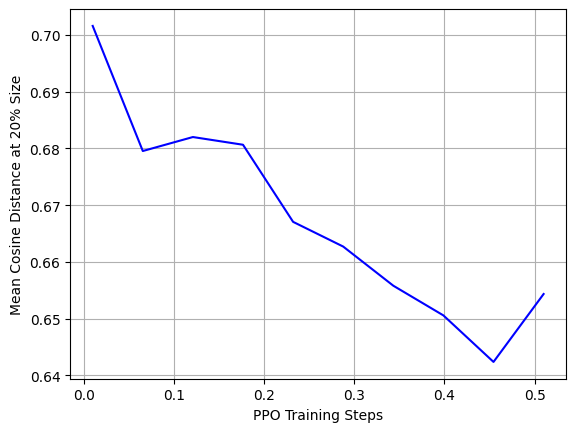

In [32]:
x = np.linspace(0.01, 0.51, len(mean_rewards))
plt.plot(x, mean_rewards, linestyle='-', color='b', label='Maximize (RL)')

plt.xlabel('PPO Training Steps')
plt.ylabel('Mean Cosine Distance at 20% Size')
plt.grid(True)
plt.show()